In [18]:
import autograd.numpy as np
from autograd import elementwise_grad
import numpy.linalg as la
from scipy.sparse import spdiags

import matplotlib.pyplot as plt
colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

In [19]:
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx
c = 1.4 # the speed, and two times the height of the wave
P = 20 # period
M = 50 # number of spatial points
x, dx = grid(P, M)
sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
u_soliton = lambda x, t: 1/2*c*sech(np.abs((x-c*t) % P - P/2))**2

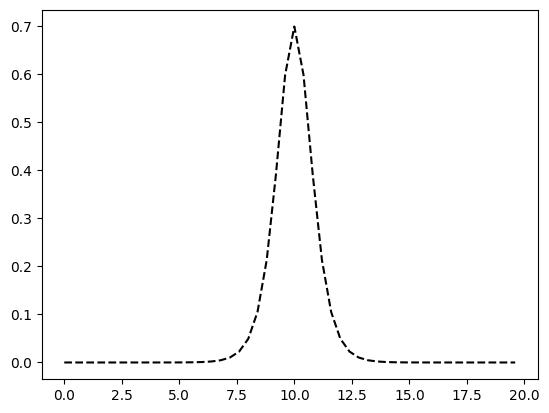

In [20]:
soliton = u_soliton(x, 0)
plt.plot(x, soliton, 'k--', label='t = 0')

In [21]:
soliton[25]

0.7

# Minimal KdV solver

In [22]:
#g = lambda x, t: 0
eta = 6.
gamma = 1.

#g = lambda x, t: 3*np.sin(2*np.pi*t)
#g = lambda x, t: np.sin(2*np.pi/P*x)*np.ones_like(t)
g = lambda x, t: 0*np.sin(2*np.pi/P*x)*np.sin(2*np.pi*t)
f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) + g(x, t)
Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)

# u0 = u_soliton(x,0) # same as above
# f = lambda u, t: -np.matmul(D1, .5*eta*u**2 + gamma**2*np.matmul(D2,u)) # same as above
#Df = lambda u: -np.matmul(D1, eta*np.diag(u) + gamma**2*D2)

In [23]:
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx
def difference_matrices(P=20, M=100):
    dx = P/M
    e = np.ones(M) # unit vector of length M
    # 1st order central difference matrix:
    D1 = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray()
    # 2nd order central difference matrix:
    D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], np.array([-M+1,-1,0,1,M-1]), M, M).toarray()
    return D1, D2

In [24]:
def midpoint_method(u,un,t,f,Df,dt,M,tol,max_iter):
    '''
    Integrating one step of the ODE u_t = f, from u to un,
    with the implicit midpoint method
    Using Newton's method to find un
    '''
    I = np.eye(M)
    F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)/2, t+.5*dt)
    J = lambda u_hat: 1/dt*I - 1/2*Df((u+u_hat)/2)
    err = la.norm(F(un))
    it = 0
    while err > tol:
        un = un - la.solve(J(un),F(un))
        err = la.norm(F(un))
        it += 1
        if it > max_iter:
            break
    return un

Let us then consider also problems that do not have an analytic solution, e.g. a system with two waves:
$$(-6/-\eta)\cdot2\cdot k_1^2\cdot \text{sech}^2(\left|k_1\cdot\left(\left(\left(x+\frac{P}{2}-P\cdot d_1\right)\bmod P\right)-\frac{P}{2}\right)\right|)$$

$\eta$: A constant that represents a coefficient.

$k_1$: A constant that represents the wave number.

$x$: A variable that represents the spatial coordinate.

$P$: A constant that represents the period of the function.

$d_1$: A constant that represents a shift in the function.

$\text{sech}$: A function that represents the hyperbolic secant.

$($ $(x + \frac{P}{2} - P \cdot d_1) \bmod P - \frac{P}{2}$ $)$: This expression calculates the position of the argument inside the period $P$, so that it always lies between $-\frac{P}{2}$ and $\frac{P}{2}$.

Initial conditions: P = 20, M = 100, k1 = 1.0, k2 = 0.75, d1 = 0.25, d2 = 0.5


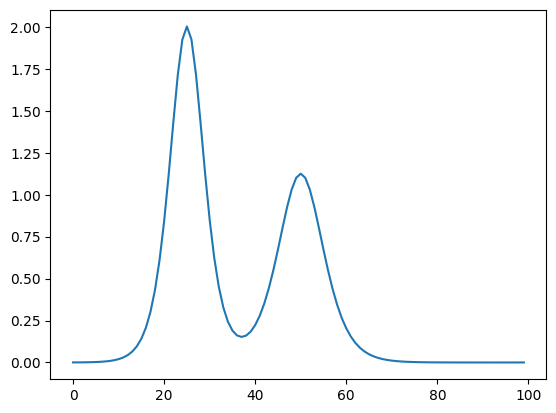

In [32]:
def initial_condition_kdv(x=np.linspace(0,20.-.2,100), eta=6.):
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))
    k1, k2 = 1., .75
    d1, d2 = .25, .5
    sech = lambda a: 1/np.cosh(a) # sech isn't defined in NumPy
    print(f"Initial conditions: P = {P}, M = {M}, k1 = {k1}, k2 = {k2}, d1 = {d1}, d2 = {d2}")
    u0 = 0
    u0 += (-6./-eta)*2 * k1**2 * sech(np.abs(k1 * ((x+P/2-P*d1) % P - P/2)))**2
    u0 += (-6./-eta)*2 * k2**2 * sech(np.abs(k2 * ((x+P/2-P*d2) % P - P/2)))**2
    u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0


P = 20 # period
M = 100 # spatial resolution. increase or decrease M to see how the approximation gets better/worse



x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)
u0 = initial_condition_kdv(x, eta)
plt.plot(u0)

In [33]:
t_max = 2
N = 100
t, dt = grid(t_max, N)
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
# The implicit midpoint method:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

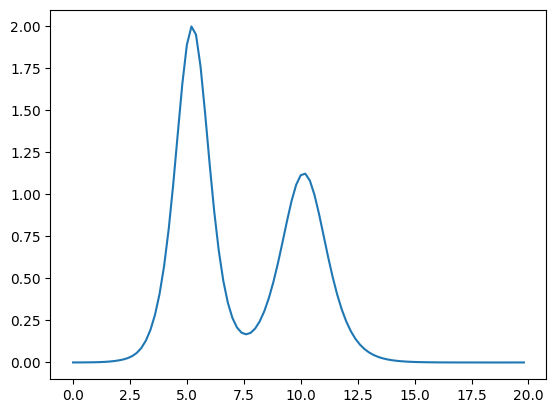

In [35]:
plt.plot(x, u[3,:], label='t=0')